In [5]:
"""
================================================================================
ANÁLISIS EXPLORATORIO DE DATOS (EDA) - PREDICCIÓN DE ANEMIA INFANTIL
ENDES 2015-2024 | ESTRATIFICACIÓN CRUZADA AÑO × ANEMIA
================================================================================

Modificaciones:
- Gráficos de distribución: formato 6x2 (6 filas, 2 columnas)
- Numeración con letras: a), b), c), etc.
- Media fija de 43.8% en gráfico de prevalencia por año
- Alta resolución (600 DPI) para evitar pixelación en Word/PDF
- Formato vectorial adicional (SVG/PDF) para máxima calidad
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import string
warnings.filterwarnings('ignore')

# ============================================================
# CONFIGURACIÓN DE ALTA CALIDAD PARA EXPORTACIÓN
# ============================================================
# Configuración para evitar pixelación en Word/PDF
plt.rcParams['figure.dpi'] = 150  # Para visualización
plt.rcParams['savefig.dpi'] = 600  # Alta resolución para guardado
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.titlesize'] = 14

# Estilo visual
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("="*80)
print("ANÁLISIS EXPLORATORIO DE DATOS (EDA) - PREDICCIÓN DE ANEMIA INFANTIL")
print("ENDES 2015-2024 | ESTRATIFICACIÓN CRUZADA AÑO × ANEMIA")
print("="*80)

# ============================================================
# DICCIONARIO DE ETIQUETAS DESCRIPTIVAS
# ============================================================
ETIQUETAS = {
    'HC1': 'Edad del niño (meses)',
    'HC70': 'Talla/Edad Z-score',
    'HV040': 'Altitud del hogar (msnm)',
    'HW2': 'Peso del niño (kg)',
    'HW3': 'Talla del niño (cm)',
    'HW70': 'Talla/Edad Z-score (antrop.)',
    'HW71': 'Peso/Edad Z-score',
    'HW72': 'Peso/Talla Z-score',
    'HW73': 'IMC Z-score',
    'BORD': 'Orden de nacimiento',
    'V012': 'Edad de la madre (años)',
    'V133': 'Educación materna (años)',
    'HC27': 'Sexo del niño',
    'HV024': 'Departamento',
    'HV025': 'Área de residencia (hogar)',
    'HV237': 'Tratamiento del agua',
    'V106': 'Nivel educativo materno',
    'V190': 'Índice de riqueza',
    'ANEMIA': 'Anemia',
    'ANIO': 'Año'
}

# Letras para numeración de subgráficos
LETRAS = list(string.ascii_lowercase)

def get_label(var):
    """Retorna la etiqueta descriptiva de una variable"""
    return ETIQUETAS.get(var, var)

def agregar_letra(ax, letra, x=-0.12, y=1.05, fontsize=14):
    """Agrega letra de numeración (a, b, c...) al subgráfico"""
    ax.text(x, y, f'{letra})', transform=ax.transAxes, 
            fontsize=fontsize, fontweight='bold', va='top', ha='left')

# ============================================================
# CONFIGURACIÓN
# ============================================================
ruta_datos = Path(r"D:\Bases_train_test")
ruta_graficos = Path(r"D:\EDA_Resultados")
ruta_graficos.mkdir(exist_ok=True)

# ============================================================
# 1. CARGAR DATOS
# ============================================================
print("\n" + "="*80)
print("1. CARGANDO DATOS")
print("="*80)

df_train = pd.read_csv(ruta_datos / "endes_train_2015_2024.csv", encoding='utf-8-sig')
df_test = pd.read_csv(ruta_datos / "endes_test_2015_2024.csv", encoding='utf-8-sig')
df_dev = pd.read_csv(ruta_datos / "endes_dev_2015_2024.csv", encoding='utf-8-sig')

print(f"\n✓ TRAIN: {len(df_train):,} registros × {df_train.shape[1]} columnas")
print(f"✓ TEST:  {len(df_test):,} registros × {df_test.shape[1]} columnas")
print(f"✓ DEV:   {len(df_dev):,} registros × {df_dev.shape[1]} columnas")

# Consolidar para EDA general
df_consolidado = pd.concat([df_train, df_test, df_dev], ignore_index=True)
print(f"\n✓ CONSOLIDADO: {len(df_consolidado):,} registros × {df_consolidado.shape[1]} columnas")

# ============================================================
# 2. INFORMACIÓN GENERAL
# ============================================================
print("\n" + "="*80)
print("2. INFORMACIÓN GENERAL DEL DATASET")
print("="*80)

print("\n📊 Tipos de datos:")
print(df_consolidado.dtypes.value_counts())

print("\n📊 Valores missing por variable:")
missing = df_consolidado.isnull().sum()
missing_pct = (missing / len(df_consolidado) * 100).round(2)
missing_df = pd.DataFrame({
    'Variable': [f"{var} ({get_label(var)})" for var in missing.index],
    'Missing': missing.values,
    'Porcentaje': missing_pct.values
})
missing_df = missing_df[missing_df['Missing'] > 0].sort_values('Missing', ascending=False)
if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("✓ No hay valores missing")

# ============================================================
# 3. ANÁLISIS DE LA VARIABLE OBJETIVO (PONDERADO)
# ============================================================
print("\n" + "="*80)
print("3. ANÁLISIS DE LA VARIABLE OBJETIVO (ANEMIA) - PONDERADO")
print("="*80)

# Verificar disponibilidad de pesos
if 'PESO' not in df_consolidado.columns:
    print("⚠️  Variable PESO no encontrada, usando conteos sin ponderar")
    usar_pesos_eda = False
else:
    usar_pesos_eda = True
    # Normalizar pesos para que sumen al tamaño de la muestra (facilita interpretación)
    df_consolidado['PESO_NORM'] = df_consolidado['PESO'] / df_consolidado['PESO'].sum() * len(df_consolidado)
    df_train['PESO_NORM'] = df_train['PESO'] / df_train['PESO'].sum() * len(df_train)
    df_test['PESO_NORM'] = df_test['PESO'] / df_test['PESO'].sum() * len(df_test)
    df_dev['PESO_NORM'] = df_dev['PESO'] / df_dev['PESO'].sum() * len(df_dev)
    print("✓ Usando pesos muestrales (variable PESO)")

fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# =====================================================
# 3.1 Distribución general PONDERADA (solo porcentajes) - a)
# =====================================================
agregar_letra(axes[0, 0], 'a')

if usar_pesos_eda:
    # Porcentajes ponderados
    peso_sin_anemia = df_consolidado[df_consolidado['ANEMIA'] == 0]['PESO_NORM'].sum()
    peso_con_anemia = df_consolidado[df_consolidado['ANEMIA'] == 1]['PESO_NORM'].sum()
    total_ponderado = peso_sin_anemia + peso_con_anemia
    pct_sin_anemia = peso_sin_anemia / total_ponderado * 100
    pct_con_anemia = peso_con_anemia / total_ponderado * 100
    titulo_dist = 'Distribución de Anemia (Ponderado)'
else:
    anemia_counts = df_consolidado['ANEMIA'].value_counts()
    total = anemia_counts.sum()
    pct_sin_anemia = anemia_counts.get(0, 0) / total * 100
    pct_con_anemia = anemia_counts.get(1, 0) / total * 100
    titulo_dist = 'Distribución de Anemia'

axes[0, 0].bar(['Sin anemia', 'Con anemia'], [pct_sin_anemia, pct_con_anemia], 
               color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=0.5)
axes[0, 0].set_title(titulo_dist, fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Porcentaje (%)')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].text(0, pct_sin_anemia + 2, f'{pct_sin_anemia:.1f}%', ha='center', fontweight='bold', fontsize=12)
axes[0, 0].text(1, pct_con_anemia + 2, f'{pct_con_anemia:.1f}%', ha='center', fontweight='bold', fontsize=12)

# =====================================================
# 3.2 Distribución por año PONDERADA (porcentajes) - b)
# =====================================================
agregar_letra(axes[0, 1], 'b')

if usar_pesos_eda:
    # Calcular porcentajes ponderados por año
    anemia_por_año_peso = df_consolidado.groupby(['ANIO', 'ANEMIA'])['PESO_NORM'].sum().unstack(fill_value=0)
    anemia_por_año_pct = anemia_por_año_peso.div(anemia_por_año_peso.sum(axis=1), axis=0) * 100
    titulo_año = 'Distribución de Anemia por Año (Ponderado)'
else:
    anemia_por_año = df_consolidado.groupby(['ANIO', 'ANEMIA']).size().unstack(fill_value=0)
    anemia_por_año_pct = anemia_por_año.div(anemia_por_año.sum(axis=1), axis=0) * 100
    titulo_año = 'Distribución de Anemia por Año'

anemia_por_año_pct.plot(kind='bar', stacked=True, ax=axes[0, 1], color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=0.5)
axes[0, 1].set_title(titulo_año, fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Año')
axes[0, 1].set_ylabel('Porcentaje (%)')
axes[0, 1].set_ylim(0, 100)
axes[0, 1].legend(['Sin anemia', 'Con anemia'], loc='upper right')
axes[0, 1].tick_params(axis='x', rotation=45)

# =====================================================
# 3.3 Prevalencia por año PONDERADA (RANGO 0-100) - c)
# =====================================================
agregar_letra(axes[1, 0], 'c')

if usar_pesos_eda:
    # Prevalencia ponderada por año
    prevalencia_año = df_consolidado.groupby('ANIO').apply(
        lambda x: (x['ANEMIA'] * x['PESO_NORM']).sum() / x['PESO_NORM'].sum() * 100
    )
    # Media ponderada global
    media_prevalencia = (df_consolidado['ANEMIA'] * df_consolidado['PESO_NORM']).sum() / df_consolidado['PESO_NORM'].sum() * 100
    titulo_prev = 'Prevalencia de Anemia por Año (Ponderado)'
else:
    prevalencia_año = df_consolidado.groupby('ANIO')['ANEMIA'].mean() * 100
    media_prevalencia = df_consolidado['ANEMIA'].mean() * 100
    titulo_prev = 'Prevalencia de Anemia por Año'

axes[1, 0].plot(prevalencia_año.index, prevalencia_año.values, marker='o', linewidth=2, markersize=8, color='#e74c3c')
axes[1, 0].axhline(y=media_prevalencia, color='gray', linestyle='--', label=f'Media: {media_prevalencia:.1f}%')
axes[1, 0].set_title(titulo_prev, fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Año')
axes[1, 0].set_ylabel('Prevalencia (%)')
axes[1, 0].set_ylim(0, 100)  # Rango fijo de 0 a 100
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
# Agregar valores en cada punto
for x, y in zip(prevalencia_año.index, prevalencia_año.values):
    axes[1, 0].annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

# =====================================================
# 3.4 Distribución por partición PONDERADA (porcentajes) - d)
# =====================================================
agregar_letra(axes[1, 1], 'd')

particiones_data = []
for name, df in [('TRAIN', df_train), ('TEST', df_test), ('DEV', df_dev)]:
    if usar_pesos_eda:
        peso_sin = df[df['ANEMIA'] == 0]['PESO_NORM'].sum()
        peso_con = df[df['ANEMIA'] == 1]['PESO_NORM'].sum()
        total = peso_sin + peso_con
        pct_sin = peso_sin / total * 100
        pct_con = peso_con / total * 100
    else:
        sin_anemia = (df['ANEMIA'] == 0).sum()
        con_anemia = (df['ANEMIA'] == 1).sum()
        total = sin_anemia + con_anemia
        pct_sin = sin_anemia / total * 100
        pct_con = con_anemia / total * 100
    
    particiones_data.append({
        'Partición': name,
        'Sin anemia': pct_sin,
        'Con anemia': pct_con
    })

df_part = pd.DataFrame(particiones_data)
x = np.arange(len(df_part))
width = 0.35

axes[1, 1].bar(x - width/2, df_part['Sin anemia'], width, label='Sin anemia', color='#2ecc71', edgecolor='black', linewidth=0.5)
axes[1, 1].bar(x + width/2, df_part['Con anemia'], width, label='Con anemia', color='#e74c3c', edgecolor='black', linewidth=0.5)
axes[1, 1].set_title('Distribución de Anemia por Partición' + (' (Ponderado)' if usar_pesos_eda else ''), fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Partición')
axes[1, 1].set_ylabel('Porcentaje (%)')
axes[1, 1].set_ylim(0, 100)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(df_part['Partición'])
axes[1, 1].legend()

# Agregar etiquetas con porcentaje
for i, row in df_part.iterrows():
    axes[1, 1].text(i - width/2, row['Sin anemia'] + 2, f'{row["Sin anemia"]:.1f}%', 
                    ha='center', fontsize=10, fontweight='bold')
    axes[1, 1].text(i + width/2, row['Con anemia'] + 2, f'{row["Con anemia"]:.1f}%', 
                    ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
# Guardar en alta resolución
plt.savefig(ruta_graficos / "01_analisis_target.png", dpi=600, bbox_inches='tight', facecolor='white')
# SVG para conversión a EMF (evita pixelación en PDF)
plt.savefig(ruta_graficos / "01_analisis_target.svg", format='svg', bbox_inches='tight', facecolor='white')
print(f"\n✓ Gráfico guardado: 01_analisis_target.png (600 DPI)")
print(f"✓ Gráfico guardado: 01_analisis_target.svg (vectorial)")
plt.close()

# Mostrar estadísticas ponderadas
print("\n📊 Estadísticas de la variable objetivo:")
if usar_pesos_eda:
    print(f"   (Valores calculados con pesos muestrales)")
    prev_global = (df_consolidado['ANEMIA'] * df_consolidado['PESO_NORM']).sum() / df_consolidado['PESO_NORM'].sum() * 100
    prev_train = (df_train['ANEMIA'] * df_train['PESO_NORM']).sum() / df_train['PESO_NORM'].sum() * 100
    prev_test = (df_test['ANEMIA'] * df_test['PESO_NORM']).sum() / df_test['PESO_NORM'].sum() * 100
    prev_dev = (df_dev['ANEMIA'] * df_dev['PESO_NORM']).sum() / df_dev['PESO_NORM'].sum() * 100
else:
    prev_global = df_consolidado['ANEMIA'].mean() * 100
    prev_train = df_train['ANEMIA'].mean() * 100
    prev_test = df_test['ANEMIA'].mean() * 100
    prev_dev = df_dev['ANEMIA'].mean() * 100

print(f"   Prevalencia global: {prev_global:.2f}%")
print(f"   TRAIN: {prev_train:.2f}%")
print(f"   TEST:  {prev_test:.2f}%")
print(f"   DEV:   {prev_dev:.2f}%")

# ============================================================
# 4. ANÁLISIS DE VARIABLES NUMÉRICAS (FORMATO 6x2)
# ============================================================
print("\n" + "="*80)
print("4. ANÁLISIS DE VARIABLES NUMÉRICAS")
print("="*80)

features_numericas = ['HC1', 'HC70', 'HV040', 'HW2', 'HW3', 'HW70', 'HW71', 'HW72', 'HW73', 'BORD', 'V012', 'V133']
features_numericas_disponibles = [f for f in features_numericas if f in df_consolidado.columns]

print(f"\nVariables numéricas disponibles: {len(features_numericas_disponibles)}")
for var in features_numericas_disponibles:
    print(f"  - {var}: {get_label(var)}")

# ============================================================
# TRANSFORMACIÓN DE VARIABLES SEGÚN FORMATO ENDES
# ============================================================
# Crear copia para no modificar el dataset original
df_consolidado_plot = df_consolidado.copy()

# Z-scores: dividir entre 100 (almacenados como centésimas)
zscore_vars = ['HC70', 'HW70', 'HW71', 'HW72', 'HW73']
for var in zscore_vars:
    if var in df_consolidado_plot.columns:
        df_consolidado_plot[var] = df_consolidado_plot[var] / 100

# Medidas físicas: dividir entre 10
# HW2: peso en decagramos → kg
if 'HW2' in df_consolidado_plot.columns:
    df_consolidado_plot['HW2'] = df_consolidado_plot['HW2'] / 10

# HW3: talla en mm → cm
if 'HW3' in df_consolidado_plot.columns:
    df_consolidado_plot['HW3'] = df_consolidado_plot['HW3'] / 10

print("\n✓ Variables transformadas:")
print("  - Z-scores (HC70, HW70-HW73): divididos entre 100")
print("  - HW2 (peso): convertido a kg")
print("  - HW3 (talla): convertido a cm")

# Actualizar etiquetas para reflejar unidades correctas
ETIQUETAS_PLOT = ETIQUETAS.copy()
ETIQUETAS_PLOT['HW2'] = 'Peso del niño (kg)'
ETIQUETAS_PLOT['HW3'] = 'Talla del niño (cm)'
ETIQUETAS_PLOT['HC70'] = 'Talla/Edad Z-score'
ETIQUETAS_PLOT['HW70'] = 'Talla/Edad Z-score (antrop.)'
ETIQUETAS_PLOT['HW71'] = 'Peso/Edad Z-score'
ETIQUETAS_PLOT['HW72'] = 'Peso/Talla Z-score'
ETIQUETAS_PLOT['HW73'] = 'IMC Z-score'

def get_label_plot(var):
    """Retorna la etiqueta para gráficos (con unidades correctas)"""
    return ETIQUETAS_PLOT.get(var, var)

# 4.1 Estadísticas descriptivas (con datos transformados)
print("\n📊 Estadísticas descriptivas (unidades corregidas):")
stats = df_consolidado_plot[features_numericas_disponibles].describe().T
stats['missing'] = df_consolidado_plot[features_numericas_disponibles].isnull().sum()
stats['missing_pct'] = (stats['missing'] / len(df_consolidado_plot) * 100).round(2)
stats.index = [f"{var} ({get_label_plot(var)})" for var in stats.index]
print(stats.to_string())

# 4.2 Distribuciones - FORMATO 6x2
n_vars = len(features_numericas_disponibles)
n_cols = 2  # Ahora 2 columnas
n_rows = 6  # 6 filas para 12 variables

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 24))  # Figura más alta
axes = axes.flatten()

for idx, var in enumerate(features_numericas_disponibles):
    data_sin_na = df_consolidado_plot[var].dropna()
    
    # Agregar letra de numeración
    agregar_letra(axes[idx], LETRAS[idx])
    
    axes[idx].hist(data_sin_na, bins=50, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.3)
    axes[idx].set_title(f'{get_label_plot(var)}\n(n={len(data_sin_na):,})', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Valor')
    axes[idx].set_ylabel('Frecuencia')
    
    # Estadísticas en el gráfico
    mean_val = data_sin_na.mean()
    median_val = data_sin_na.median()
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Media: {mean_val:.1f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=1.5, label=f'Mediana: {median_val:.1f}')
    axes[idx].legend(fontsize=8, loc='upper right')
    axes[idx].grid(True, alpha=0.3)

# Ocultar ejes vacíos si hay menos de 12 variables
for idx in range(len(features_numericas_disponibles), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(ruta_graficos / "02_distribucion_numericas.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig(ruta_graficos / "02_distribucion_numericas.svg", format='svg', bbox_inches='tight', facecolor='white')
print(f"\n✓ Gráfico guardado: 02_distribucion_numericas.png (600 DPI, formato 6x2)")
print(f"✓ Gráfico guardado: 02_distribucion_numericas.svg (vectorial)")
plt.close()

# ============================================================
# 5. ANÁLISIS DE VARIABLES CATEGÓRICAS
# ============================================================
print("\n" + "="*80)
print("5. ANÁLISIS DE VARIABLES CATEGÓRICAS")
print("="*80)

features_categoricas = ['HC27', 'HV024', 'HV025', 'HV237', 'V106', 'V190']
features_categoricas_disponibles = [f for f in features_categoricas if f in df_consolidado.columns]

print(f"\nVariables categóricas disponibles: {len(features_categoricas_disponibles)}")
for var in features_categoricas_disponibles:
    print(f"  - {var}: {get_label(var)}")

# 5.1 Frecuencias
for var in features_categoricas_disponibles:
    print(f"\n📊 {var} ({get_label(var)}):")
    freq = df_consolidado[var].value_counts()
    freq_pct = df_consolidado[var].value_counts(normalize=True) * 100
    freq_df = pd.DataFrame({'Frecuencia': freq, 'Porcentaje': freq_pct.round(2)})
    print(freq_df.head(10).to_string())

# 5.2 Visualización
n_vars = len(features_categoricas_disponibles)
n_cols = 2
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4.5))
axes = axes.flatten()

for idx, var in enumerate(features_categoricas_disponibles):
    freq = df_consolidado[var].value_counts().head(15)
    
    # Agregar letra de numeración
    agregar_letra(axes[idx], LETRAS[idx])
    
    axes[idx].barh(range(len(freq)), freq.values, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.3)
    axes[idx].set_yticks(range(len(freq)))
    axes[idx].set_yticklabels(freq.index, fontsize=9)
    axes[idx].set_title(f'{get_label(var)}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Frecuencia')
    axes[idx].invert_yaxis()
    
    # Agregar valores
    for i, v in enumerate(freq.values):
        axes[idx].text(v + 100, i, f'{v:,}', va='center', fontsize=8)

# Ocultar ejes vacíos
for idx in range(len(features_categoricas_disponibles), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(ruta_graficos / "03_distribucion_categoricas.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig(ruta_graficos / "03_distribucion_categoricas.svg", format='svg', bbox_inches='tight', facecolor='white')
print(f"\n✓ Gráfico guardado: 03_distribucion_categoricas.png (600 DPI)")
print(f"✓ Gráfico guardado: 03_distribucion_categoricas.svg (vectorial)")
plt.close()

# ============================================================
# 6. RELACIÓN VARIABLES NUMÉRICAS CON ANEMIA (FORMATO 6x2)
# ============================================================
print("\n" + "="*80)
print("6. RELACIÓN DE VARIABLES NUMÉRICAS CON ANEMIA")
print("="*80)

n_vars = len(features_numericas_disponibles)
n_cols = 2  # Ahora 2 columnas
n_rows = 6  # 6 filas para 12 variables

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 24))
axes = axes.flatten()

for idx, var in enumerate(features_numericas_disponibles):
    data_sin_anemia = df_consolidado_plot[df_consolidado_plot['ANEMIA'] == 0][var].dropna()
    data_con_anemia = df_consolidado_plot[df_consolidado_plot['ANEMIA'] == 1][var].dropna()
    
    # Agregar letra de numeración
    agregar_letra(axes[idx], LETRAS[idx])
    
    axes[idx].hist(data_sin_anemia, bins=30, alpha=0.5, label='Sin anemia', color='#2ecc71', edgecolor='black', linewidth=0.3)
    axes[idx].hist(data_con_anemia, bins=30, alpha=0.5, label='Con anemia', color='#e74c3c', edgecolor='black', linewidth=0.3)
    axes[idx].set_title(f'{get_label_plot(var)}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Valor')
    axes[idx].set_ylabel('Frecuencia')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)

# Ocultar ejes vacíos si hay menos de 12 variables
for idx in range(len(features_numericas_disponibles), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(ruta_graficos / "04_numericas_vs_anemia.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig(ruta_graficos / "04_numericas_vs_anemia.svg", format='svg', bbox_inches='tight', facecolor='white')
print(f"\n✓ Gráfico guardado: 04_numericas_vs_anemia.png (600 DPI, formato 6x2)")
print(f"✓ Gráfico guardado: 04_numericas_vs_anemia.svg (vectorial)")
plt.close()

# ============================================================
# 7. RELACIÓN VARIABLES CATEGÓRICAS CON ANEMIA
# ============================================================
print("\n" + "="*80)
print("7. RELACIÓN DE VARIABLES CATEGÓRICAS CON ANEMIA")
print("="*80)

# Calcular media de prevalencia (ponderada si está disponible) para usar en los gráficos
if usar_pesos_eda:
    media_prevalencia = (df_consolidado['ANEMIA'] * df_consolidado['PESO_NORM']).sum() / df_consolidado['PESO_NORM'].sum() * 100
else:
    media_prevalencia = df_consolidado['ANEMIA'].mean() * 100

# Seleccionar variables clave para analizar
vars_clave = ['HV025', 'HV024', 'V106', 'V190', 'HC27']
vars_clave_disponibles = [v for v in vars_clave if v in df_consolidado.columns]

n_vars = min(len(vars_clave_disponibles), 6)
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
axes = axes.flatten()

for idx, var in enumerate(vars_clave_disponibles[:6]):
    # Calcular prevalencia por categoría
    prev_data = df_consolidado.groupby(var)['ANEMIA'].agg(['sum', 'count'])
    prev_data['prevalencia'] = (prev_data['sum'] / prev_data['count'] * 100)
    prev_data = prev_data.sort_values('prevalencia', ascending=False).head(15)
    
    # Agregar letra de numeración
    agregar_letra(axes[idx], LETRAS[idx])
    
    axes[idx].barh(range(len(prev_data)), prev_data['prevalencia'].values, color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=0.3)
    axes[idx].set_yticks(range(len(prev_data)))
    axes[idx].set_yticklabels(prev_data.index, fontsize=9)
    axes[idx].set_title(f'Prevalencia de Anemia por {get_label(var)}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Prevalencia (%)')
    axes[idx].invert_yaxis()
    # Media calculada
    axes[idx].axvline(media_prevalencia, color='gray', linestyle='--', 
                      label=f'Media: {media_prevalencia:.1f}%')
    axes[idx].legend(fontsize=8)
    
    # Agregar valores
    for i, v in enumerate(prev_data['prevalencia'].values):
        axes[idx].text(v + 1, i, f'{v:.1f}%', va='center', fontsize=8)

# Ocultar ejes vacíos
for idx in range(len(vars_clave_disponibles), 6):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(ruta_graficos / "05_categoricas_vs_anemia.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig(ruta_graficos / "05_categoricas_vs_anemia.svg", format='svg', bbox_inches='tight', facecolor='white')
print(f"\n✓ Gráfico guardado: 05_categoricas_vs_anemia.png (600 DPI)")
print(f"✓ Gráfico guardado: 05_categoricas_vs_anemia.svg (vectorial)")
plt.close()

# ============================================================
# 8. MATRIZ DE CORRELACIÓN
# ============================================================
print("\n" + "="*80)
print("8. MATRIZ DE CORRELACIÓN (Variables Numéricas)")
print("="*80)

# Seleccionar variables numéricas + ANEMIA (usando datos transformados)
vars_corr = features_numericas_disponibles + ['ANEMIA']
df_corr = df_consolidado_plot[vars_corr].dropna()

corr_matrix = df_corr.corr()

# Crear etiquetas con nombres descriptivos
labels_corr = [get_label_plot(var) for var in corr_matrix.columns]

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            xticklabels=labels_corr, yticklabels=labels_corr,
            annot_kws={'size': 8})
plt.title('Matriz de Correlación - Variables Numéricas', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig(ruta_graficos / "06_matriz_correlacion.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig(ruta_graficos / "06_matriz_correlacion.svg", format='svg', bbox_inches='tight', facecolor='white')
print(f"\n✓ Gráfico guardado: 06_matriz_correlacion.png (600 DPI)")
print(f"✓ Gráfico guardado: 06_matriz_correlacion.svg (vectorial)")
plt.close()

# Correlaciones más altas con ANEMIA
print("\n📊 Correlaciones con ANEMIA (ordenadas):")
corr_con_anemia = corr_matrix['ANEMIA'].drop('ANEMIA').sort_values(ascending=False)
for var, corr in corr_con_anemia.items():
    print(f"   {get_label_plot(var):40s}: {corr:7.4f}")

# ============================================================
# 9. ANÁLISIS GEOGRÁFICO
# ============================================================
print("\n" + "="*80)
print("9. ANÁLISIS GEOGRÁFICO")
print("="*80)

if 'HV024' in df_consolidado.columns:
    # Prevalencia por departamento
    prev_dept = df_consolidado.groupby('HV024').agg({
        'ANEMIA': ['sum', 'count', 'mean']
    })
    prev_dept.columns = ['Con_Anemia', 'Total', 'Prevalencia']
    prev_dept['Prevalencia'] = prev_dept['Prevalencia'] * 100
    prev_dept = prev_dept.sort_values('Prevalencia', ascending=False)
    
    print("\n📊 Prevalencia de anemia por departamento:")
    print(prev_dept.to_string())
    
    # Top 10 y Bottom 10
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    # Top 10 - a)
    top10 = prev_dept.head(10)
    agregar_letra(axes[0], 'a')
    axes[0].barh(range(len(top10)), top10['Prevalencia'].values, color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=0.5)
    axes[0].set_yticks(range(len(top10)))
    axes[0].set_yticklabels(top10.index, fontsize=10)
    axes[0].set_title('Top 10 Departamentos con Mayor Prevalencia', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Prevalencia (%)')
    axes[0].invert_yaxis()
    for i, v in enumerate(top10['Prevalencia'].values):
        axes[0].text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=9, fontweight='bold')
    
    # Bottom 10 - b)
    bottom10 = prev_dept.tail(10).sort_values('Prevalencia', ascending=True)
    agregar_letra(axes[1], 'b')
    axes[1].barh(range(len(bottom10)), bottom10['Prevalencia'].values, color='#2ecc71', alpha=0.7, edgecolor='black', linewidth=0.5)
    axes[1].set_yticks(range(len(bottom10)))
    axes[1].set_yticklabels(bottom10.index, fontsize=10)
    axes[1].set_title('Top 10 Departamentos con Menor Prevalencia', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Prevalencia (%)')
    axes[1].invert_yaxis()
    for i, v in enumerate(bottom10['Prevalencia'].values):
        axes[1].text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(ruta_graficos / "07_analisis_geografico.png", dpi=600, bbox_inches='tight', facecolor='white')
    plt.savefig(ruta_graficos / "07_analisis_geografico.svg", format='svg', bbox_inches='tight', facecolor='white')
    print(f"\n✓ Gráfico guardado: 07_analisis_geografico.png (600 DPI)")
    print(f"✓ Gráfico guardado: 07_analisis_geografico.svg (vectorial)")
    plt.close()

# ============================================================
# 10. RESUMEN EJECUTIVO
# ============================================================
print("\n" + "="*80)
print("✅ ANÁLISIS EXPLORATORIO COMPLETADO")
print("="*80)

print(f"\n📁 Gráficos generados en: {ruta_graficos}")
print("\n📊 Archivos generados (PNG 600 DPI + SVG vectorial):")
print("   1. 01_analisis_target.png/svg")
print("   2. 02_distribucion_numericas.png/svg (formato 6x2)")
print("   3. 03_distribucion_categoricas.png/svg")
print("   4. 04_numericas_vs_anemia.png/svg (formato 6x2)")
print("   5. 05_categoricas_vs_anemia.png/svg")
print("   6. 06_matriz_correlacion.png/svg")
print("   7. 07_analisis_geografico.png/svg")

print("\n💡 Notas sobre calidad de imagen:")
print("   - PNG: 600 DPI (alta resolución)")
print("   - SVG: Formato vectorial (convertir a EMF para Word)")
print("   - Flujo recomendado: SVG → EMF → Word → PDF (sin pixelación)")

print("\n💡 Próximos pasos:")
print("   1. Revisar gráficos generados")
print("   2. Identificar patrones y relaciones")
print("   3. Proceder con el modelado")

ANÁLISIS EXPLORATORIO DE DATOS (EDA) - PREDICCIÓN DE ANEMIA INFANTIL
ENDES 2015-2024 | ESTRATIFICACIÓN CRUZADA AÑO × ANEMIA

1. CARGANDO DATOS

✓ TRAIN: 92,030 registros × 43 columnas
✓ TEST:  26,291 registros × 43 columnas
✓ DEV:   13,147 registros × 43 columnas

✓ CONSOLIDADO: 131,468 registros × 43 columnas

2. INFORMACIÓN GENERAL DEL DATASET

📊 Tipos de datos:
float64    26
object     14
int64       3
Name: count, dtype: int64

📊 Valores missing por variable:
                           Variable  Missing  Porcentaje
                    HV005X (HV005X)   115651       87.97
                      HV007 (HV007)    14689       11.17
           HW71 (Peso/Edad Z-score)     9924        7.55
                 HW73 (IMC Z-score)     9924        7.55
          HW72 (Peso/Talla Z-score)     9924        7.55
HW70 (Talla/Edad Z-score (antrop.))     9924        7.55
          HW3 (Talla del niño (cm))     9722        7.39
           HW2 (Peso del niño (kg))     9712        7.39
                   

In [7]:
"""
================================================================================
DISTRIBUCIÓN DE VARIABLES CATEGÓRICAS SEGÚN ESTADO DE ANEMIA
Gráficos de columnas apiladas - Formato 3x2
================================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import string
warnings.filterwarnings('ignore')

# ============================================================
# CONFIGURACIÓN DE ALTA CALIDAD PARA EXPORTACIÓN
# ============================================================
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

plt.style.use('seaborn-v0_8-whitegrid')

# Letras para numeración
LETRAS = list(string.ascii_lowercase)

def agregar_letra(ax, letra, x=-0.08, y=1.05, fontsize=14):
    """Agrega letra de numeración al subgráfico"""
    ax.text(x, y, f'{letra})', transform=ax.transAxes, 
            fontsize=fontsize, fontweight='bold', va='top', ha='left')

# ============================================================
# CONFIGURACIÓN DE RUTAS
# ============================================================
ruta_datos = Path(r"D:\Bases_train_test")
ruta_graficos = Path(r"D:\EDA_Resultados")
ruta_graficos.mkdir(exist_ok=True)

# ============================================================
# CARGAR DATOS
# ============================================================
print("="*80)
print("DISTRIBUCIÓN DE VARIABLES CATEGÓRICAS SEGÚN ESTADO DE ANEMIA")
print("="*80)

print("\nCargando datos...")
df_train = pd.read_csv(ruta_datos / "endes_train_2015_2024.csv", encoding='utf-8-sig')
df_test = pd.read_csv(ruta_datos / "endes_test_2015_2024.csv", encoding='utf-8-sig')
df_dev = pd.read_csv(ruta_datos / "endes_dev_2015_2024.csv", encoding='utf-8-sig')

df_consolidado = pd.concat([df_train, df_test, df_dev], ignore_index=True)
print(f"✓ Dataset consolidado: {len(df_consolidado):,} registros")

# ============================================================
# DICCIONARIO DE ETIQUETAS
# ============================================================
ETIQUETAS = {
    'HC27': 'Sexo del niño',
    'HV024': 'Departamento',
    'HV025': 'Área de residencia',
    'HV237': 'Tratamiento del agua',
    'V106': 'Nivel educativo materno',
    'V190': 'Índice de riqueza'
}

# Orden específico para variables ordinales
ORDEN_CATEGORIAS = {
    'V106': ['sin educación', 'primaria', 'secundaria', 'superior'],
    'V190': ['más pobre', 'pobre', 'medio', 'rico', 'más rico'],
    'HV025': ['urbano', 'rural'],
    'HC27': ['hombre', 'mujer'],
    'HV237': ['sí', 'no']
}

def get_label(var):
    return ETIQUETAS.get(var, var)

# ============================================================
# PREPARAR PESOS
# ============================================================
if 'PESO' in df_consolidado.columns:
    df_consolidado['PESO_NORM'] = df_consolidado['PESO'] / df_consolidado['PESO'].sum() * len(df_consolidado)
    usar_pesos = True
    print("✓ Usando pesos muestrales")
else:
    usar_pesos = False
    print("⚠️ Sin pesos muestrales")

# ============================================================
# VARIABLES A ANALIZAR (sin HV024 por tener muchas categorías)
# ============================================================
variables_cat = ['HC27', 'HV025', 'HV237', 'V106', 'V190']
variables_disponibles = [v for v in variables_cat if v in df_consolidado.columns]

print(f"\nVariables a analizar: {len(variables_disponibles)}")

# ============================================================
# GENERAR GRÁFICO DE COLUMNAS APILADAS
# ============================================================
n_vars = len(variables_disponibles)
n_cols = 2
n_rows = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 15))
axes = axes.flatten()

for idx, var in enumerate(variables_disponibles):
    agregar_letra(axes[idx], LETRAS[idx])
    
    # Calcular porcentajes por categoría y estado de anemia
    if usar_pesos:
        # Tabla cruzada ponderada
        tabla = df_consolidado.groupby([var, 'ANEMIA'])['PESO_NORM'].sum().unstack(fill_value=0)
    else:
        tabla = pd.crosstab(df_consolidado[var], df_consolidado['ANEMIA'])
    
    # Renombrar columnas
    tabla.columns = ['Sin anemia', 'Con anemia']
    
    # Calcular porcentajes (cada categoría suma 100%)
    tabla_pct = tabla.div(tabla.sum(axis=1), axis=0) * 100
    
    # Ordenar categorías si hay orden definido
    if var in ORDEN_CATEGORIAS:
        orden = [c for c in ORDEN_CATEGORIAS[var] if c in tabla_pct.index]
        tabla_pct = tabla_pct.reindex(orden)
    
    # Graficar columnas apiladas
    tabla_pct.plot(kind='bar', stacked=True, ax=axes[idx], 
                   color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=0.5)
    
    axes[idx].set_title(f'{get_label(var)}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Porcentaje (%)')
    axes[idx].set_ylim(0, 100)
    axes[idx].legend(loc='upper right', fontsize=9)
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Agregar etiquetas de porcentaje en las barras
    for i, (categoria, row) in enumerate(tabla_pct.iterrows()):
        # Porcentaje sin anemia (parte inferior)
        if row['Sin anemia'] > 5:
            axes[idx].text(i, row['Sin anemia']/2, f'{row["Sin anemia"]:.1f}%', 
                          ha='center', va='center', fontsize=9, fontweight='bold', color='white')
        # Porcentaje con anemia (parte superior)
        if row['Con anemia'] > 5:
            axes[idx].text(i, row['Sin anemia'] + row['Con anemia']/2, f'{row["Con anemia"]:.1f}%', 
                          ha='center', va='center', fontsize=9, fontweight='bold', color='white')

# Ocultar ejes vacíos
for idx in range(len(variables_disponibles), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(ruta_graficos / "08_categoricas_vs_anemia_apiladas.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig(ruta_graficos / "08_categoricas_vs_anemia_apiladas.svg", format='svg', bbox_inches='tight', facecolor='white')
print(f"\n✓ Gráfico guardado: 08_categoricas_vs_anemia_apiladas.png")
print(f"✓ Gráfico guardado: 08_categoricas_vs_anemia_apiladas.svg")
plt.close()

# ============================================================
# IMPRIMIR TABLA RESUMEN
# ============================================================
print("\n" + "="*80)
print("RESUMEN: PREVALENCIA DE ANEMIA POR CATEGORÍA")
print("="*80)

for var in variables_disponibles:
    print(f"\n{get_label(var)}:")
    print("-" * 50)
    
    if usar_pesos:
        tabla = df_consolidado.groupby([var, 'ANEMIA'])['PESO_NORM'].sum().unstack(fill_value=0)
    else:
        tabla = pd.crosstab(df_consolidado[var], df_consolidado['ANEMIA'])
    
    tabla.columns = ['Sin anemia', 'Con anemia']
    tabla['Total'] = tabla.sum(axis=1)
    tabla['% Anemia'] = (tabla['Con anemia'] / tabla['Total'] * 100).round(1)
    
    # Ordenar
    if var in ORDEN_CATEGORIAS:
        orden = [c for c in ORDEN_CATEGORIAS[var] if c in tabla.index]
        tabla = tabla.reindex(orden)
    
    print(tabla[['% Anemia']].to_string())

print("\n" + "="*80)
print("✅ PROCESO COMPLETADO")
print("="*80)

DISTRIBUCIÓN DE VARIABLES CATEGÓRICAS SEGÚN ESTADO DE ANEMIA

Cargando datos...
✓ Dataset consolidado: 131,468 registros
✓ Usando pesos muestrales

Variables a analizar: 5

✓ Gráfico guardado: 08_categoricas_vs_anemia_apiladas.png
✓ Gráfico guardado: 08_categoricas_vs_anemia_apiladas.svg

RESUMEN: PREVALENCIA DE ANEMIA POR CATEGORÍA

Sexo del niño:
--------------------------------------------------
        % Anemia
HC27            
hombre      46.1
mujer       41.4

Área de residencia:
--------------------------------------------------
        % Anemia
HV025           
urbano      40.3
rural       52.4

Tratamiento del agua:
--------------------------------------------------
       % Anemia
HV237          
sí         42.8
no         52.1

Nivel educativo materno:
--------------------------------------------------
               % Anemia
V106                   
sin educación      52.8
primaria           52.0
secundaria         46.5
superior           34.0

Índice de riqueza:
-----------

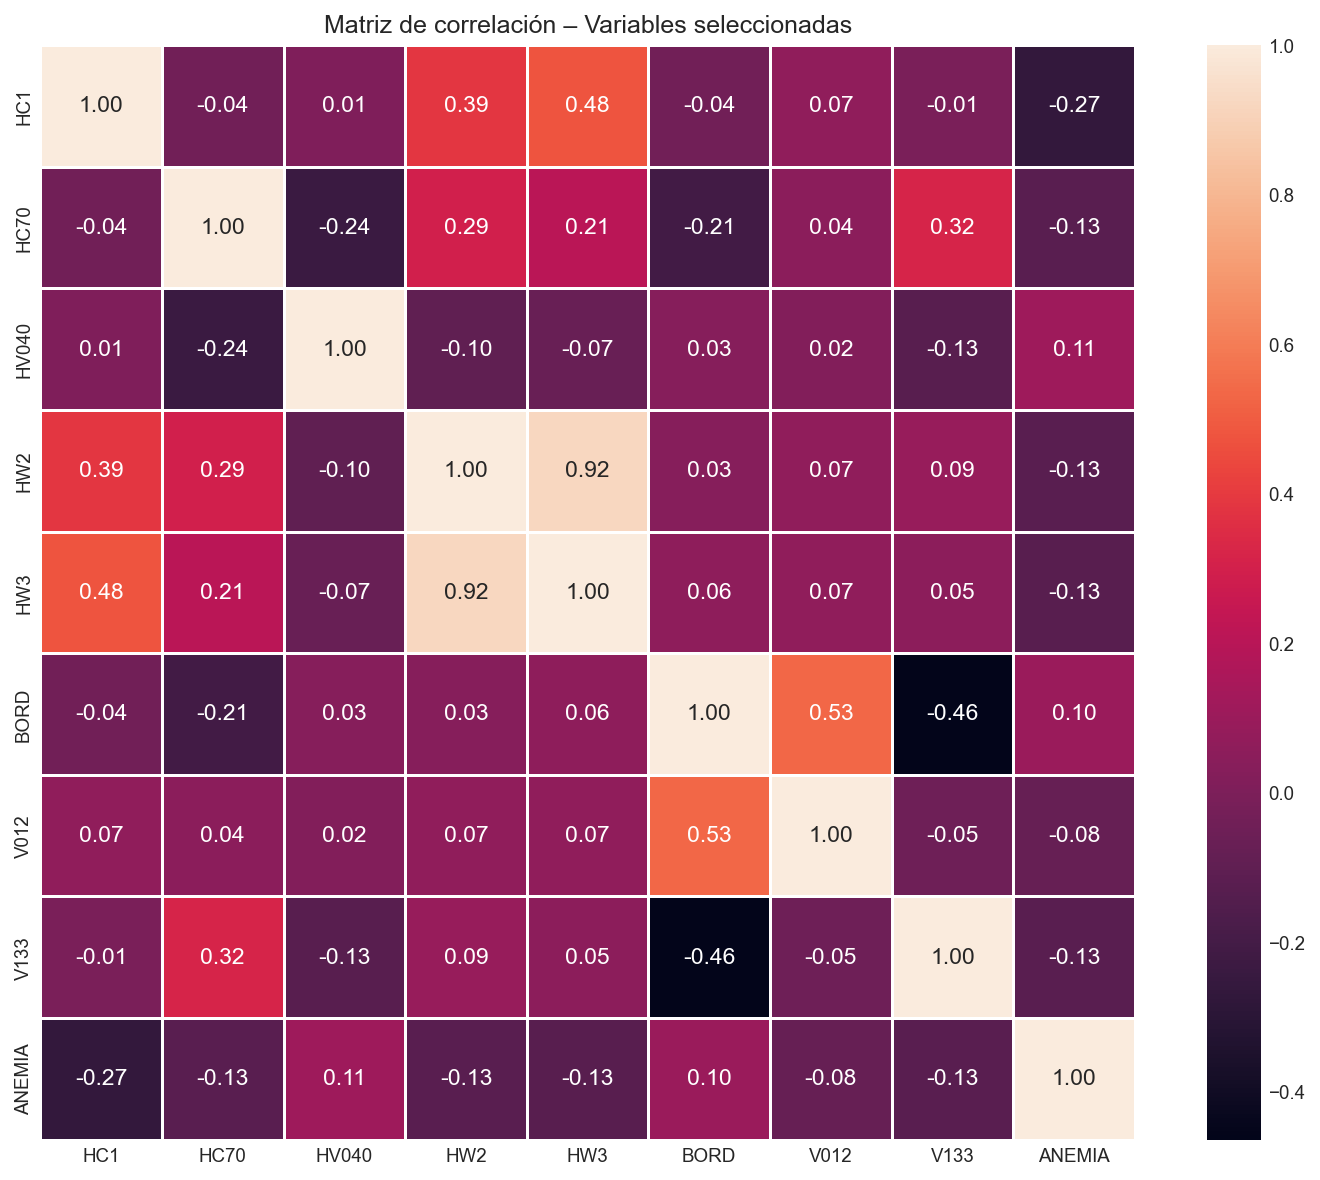

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# INGESTA DE DATOS
# -----------------------------
df = df_consolidado

# -----------------------------
# VARIABLES SELECCIONADAS
# -----------------------------
vars_corr = [
    "HC1",
    "HC70",
    "HV040",
    "HW2",
    "HW3",
    #"HV271",
    "BORD",
    "V012",
    "V133",
    "ANEMIA"  # reemplaza por el nombre exacto de tu variable objetivo
]

df_corr = df[vars_corr]

# -----------------------------
# MATRIZ DE CORRELACIÓN
# -----------------------------
corr_matrix = df_corr.corr(method="pearson")

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5
)
plt.title("Matriz de correlación – Variables seleccionadas")
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from pathlib import Path

print("="*80)
print("PRUEBAS DE CHI-CUADRADO: VARIABLES CATEGÓRICAS vs ANEMIA")
print("="*80)

# Configuración
ruta_datos = Path(r"D:\Bases_train_test")

# Cargar datos
df_train = pd.read_csv(ruta_datos / "endes_train_2015_2024.csv", encoding='utf-8-sig')
df_test = pd.read_csv(ruta_datos / "endes_test_2015_2024.csv", encoding='utf-8-sig')
df_dev = pd.read_csv(ruta_datos / "endes_dev_2015_2024.csv", encoding='utf-8-sig')
df_consolidado = pd.concat([df_train, df_test, df_dev], ignore_index=True)

print(f"\n✓ Dataset consolidado: {len(df_consolidado):,} registros")

# Variables categóricas a analizar
variables_categoricas = {
    'HC27': 'Sexo del niño',
    'HV024': 'Departamento',
    'HV025': 'Área de residencia',
    'HV237': 'Tratamiento del agua',
    'V106': 'Nivel educativo materno',
    'V190': 'Índice de riqueza'
}

# Resultados
resultados = []

print("\n" + "="*80)
print("CALCULANDO PRUEBAS CHI-CUADRADO")
print("="*80)

for var, descripcion in variables_categoricas.items():
    if var in df_consolidado.columns:
        # Crear tabla de contingencia
        tabla_contingencia = pd.crosstab(
            df_consolidado[var], 
            df_consolidado['ANEMIA'],
            dropna=True
        )
        
        # Realizar prueba chi-cuadrado
        chi2, p_value, dof, expected = chi2_contingency(tabla_contingencia)
        
        # Calcular V de Cramér (medida de tamaño del efecto)
        n = tabla_contingencia.sum().sum()
        min_dim = min(tabla_contingencia.shape[0] - 1, tabla_contingencia.shape[1] - 1)
        cramer_v = np.sqrt(chi2 / (n * min_dim))
        
        # Determinar significancia
        if p_value < 0.001:
            sig = "***"
        elif p_value < 0.01:
            sig = "**"
        elif p_value < 0.05:
            sig = "*"
        else:
            sig = "ns"
        
        # Interpretación de V de Cramér
        if cramer_v < 0.1:
            efecto = "Muy débil"
        elif cramer_v < 0.3:
            efecto = "Débil"
        elif cramer_v < 0.5:
            efecto = "Moderado"
        else:
            efecto = "Fuerte"
        
        resultados.append({
            'Variable': f"{var} ({descripcion})",
            'Chi-cuadrado': chi2,
            'gl': dof,
            'p-valor': p_value,
            'V de Cramér': cramer_v,
            'Tamaño efecto': efecto,
            'Significancia': sig
        })
        
        print(f"\n✓ {descripcion} ({var}):")
        print(f"   χ² = {chi2:,.2f}, gl = {dof}, p < {p_value:.4f} {sig}")
        print(f"   V de Cramér = {cramer_v:.4f} ({efecto})")
        print(f"   Categorías: {len(tabla_contingencia)}")

# Crear DataFrame de resultados
df_resultados = pd.DataFrame(resultados)

print("\n" + "="*80)
print("RESUMEN DE RESULTADOS")
print("="*80)
print("\n" + df_resultados.to_string(index=False))

# Guardar resultados
ruta_salida = Path(r"D:\EDA_Resultados")
df_resultados.to_csv(ruta_salida / "chi_cuadrado_resultados.csv", index=False, encoding='utf-8-sig')
print(f"\n✓ Resultados guardados en: {ruta_salida / 'chi_cuadrado_resultados.csv'}")

print("\n" + "="*80)
print("INTERPRETACIÓN")
print("="*80)
print("\nSignificancia estadística:")
print("  *** p < 0.001 (altamente significativo)")
print("  **  p < 0.01  (muy significativo)")
print("  *   p < 0.05  (significativo)")
print("  ns  p ≥ 0.05  (no significativo)")

print("\nTamaño del efecto (V de Cramér):")
print("  < 0.1  : Muy débil")
print("  0.1-0.3: Débil")
print("  0.3-0.5: Moderado")
print("  > 0.5  : Fuerte")

print("\n" + "="*80)
print("✅ ANÁLISIS COMPLETADO")
print("="*80)

PRUEBAS DE CHI-CUADRADO: VARIABLES CATEGÓRICAS vs ANEMIA

✓ Dataset consolidado: 131,468 registros

CALCULANDO PRUEBAS CHI-CUADRADO

✓ Sexo del niño (HC27):
   χ² = 281.79, gl = 1, p < 0.0000 ***
   V de Cramér = 0.0463 (Muy débil)
   Categorías: 2

✓ Departamento (HV024):
   χ² = 4,638.02, gl = 24, p < 0.0000 ***
   V de Cramér = 0.1878 (Débil)
   Categorías: 25

✓ Área de residencia (HV025):
   χ² = 1,427.39, gl = 1, p < 0.0000 ***
   V de Cramér = 0.1042 (Débil)
   Categorías: 2

✓ Tratamiento del agua (HV237):
   χ² = 377.88, gl = 1, p < 0.0000 ***
   V de Cramér = 0.0536 (Muy débil)
   Categorías: 2

✓ Nivel educativo materno (V106):
   χ² = 2,189.63, gl = 3, p < 0.0000 ***
   V de Cramér = 0.1326 (Débil)
   Categorías: 4

✓ Índice de riqueza (V190):
   χ² = 3,976.86, gl = 4, p < 0.0000 ***
   V de Cramér = 0.1787 (Débil)
   Categorías: 5

RESUMEN DE RESULTADOS

                      Variable  Chi-cuadrado  gl      p-valor  V de Cramér Tamaño efecto Significancia
          HC27 (S